In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/complete-reddit/posts_train.csv
/kaggle/input/complete-reddit/posts_val.csv
/kaggle/input/complete-reddit/posts_test.csv
/kaggle/input/complete-reddit/titles_test.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt



2024-05-26 15:02:33.489957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 15:02:33.490056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 15:02:33.618722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load data
df = pd.read_csv("/kaggle/input/complete-reddit/posts_train.csv")

# Prepare data
data_texts = df["post"].to_list()
data_labels = df["class_id"].to_list()



In [4]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [5]:
# Tokenize data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
# Convert tokenized inputs to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

In [7]:
# Initialize DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [8]:
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertConfig

# Load the pre-trained DistilBERT model
config = DistilBertConfig()
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
# Define input layers
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

In [10]:
# Pass through DistilBERT
distilbert_outputs = distilbert_model(input_ids, attention_mask=attention_mask)
sequence_output = distilbert_outputs.last_hidden_state

In [11]:
# Add BiLSTM layers
bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(sequence_output)
bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bilstm1)
bilstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bilstm2)


In [12]:
# GlobalMaxPooling1D layer
pooling = tf.keras.layers.GlobalMaxPooling1D()(bilstm3)

# Add fully connected layers
hidden1 = tf.keras.layers.Dense(128, activation='relu')(pooling)
hidden2 = tf.keras.layers.Dropout(0.1)(hidden1)
output = tf.keras.layers.Dense(6, activation='softmax')(hidden2)


In [13]:
# Define the model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [14]:
# Print the model summary
print("Model summary:")
model.summary()


Model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, None, 768   0          'attention_mask[0][0]']      
                             ),                                                

In [15]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [16]:
# Assume train_dataset and val_dataset are already defined
# Ensure that train_dataset and val_dataset provide a dictionary with keys 'input_ids' and 'attention_mask'
history = model.fit(
    train_dataset.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE),
    epochs=25,
    validation_data=val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
)

Epoch 1/25


I0000 00:00:1716735978.774091      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


680/680 [==============================] - 535s 699ms/step - loss: 1.0053 - accuracy: 0.6877 - val_loss: 0.7323 - val_accuracy: 0.7728
Epoch 2/25
680/680 [==============================] - 468s 688ms/step - loss: 0.6388 - accuracy: 0.8068 - val_loss: 0.6529 - val_accuracy: 0.7921
Epoch 3/25
680/680 [==============================] - 468s 688ms/step - loss: 0.4895 - accuracy: 0.8567 - val_loss: 0.6497 - val_accuracy: 0.7972
Epoch 4/25
680/680 [==============================] - 467s 687ms/step - loss: 0.3833 - accuracy: 0.8866 - val_loss: 0.6997 - val_accuracy: 0.7946
Epoch 5/25
680/680 [==============================] - 467s 687ms/step - loss: 0.2806 - accuracy: 0.9244 - val_loss: 0.7187 - val_accuracy: 0.7928
Epoch 6/25
680/680 [==============================] - 467s 687ms/step - loss: 0.2222 - accuracy: 0.9407 - val_loss: 0.7613 - val_accuracy: 0.7953
Epoch 7/25
680/680 [==============================] - 467s 687ms/step - loss: 0.1845 - accuracy: 0.9535 - val_loss: 0.8034 - val_accura

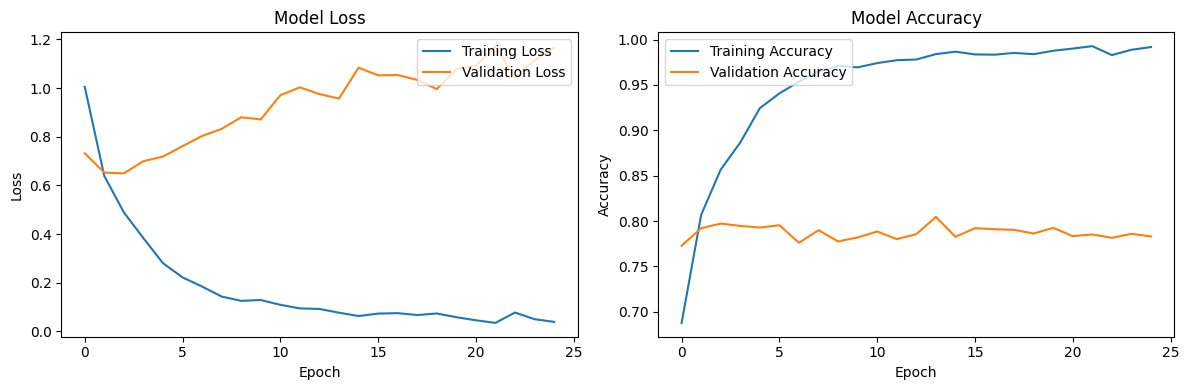

172/172 [==============================] - 47s 229ms/step


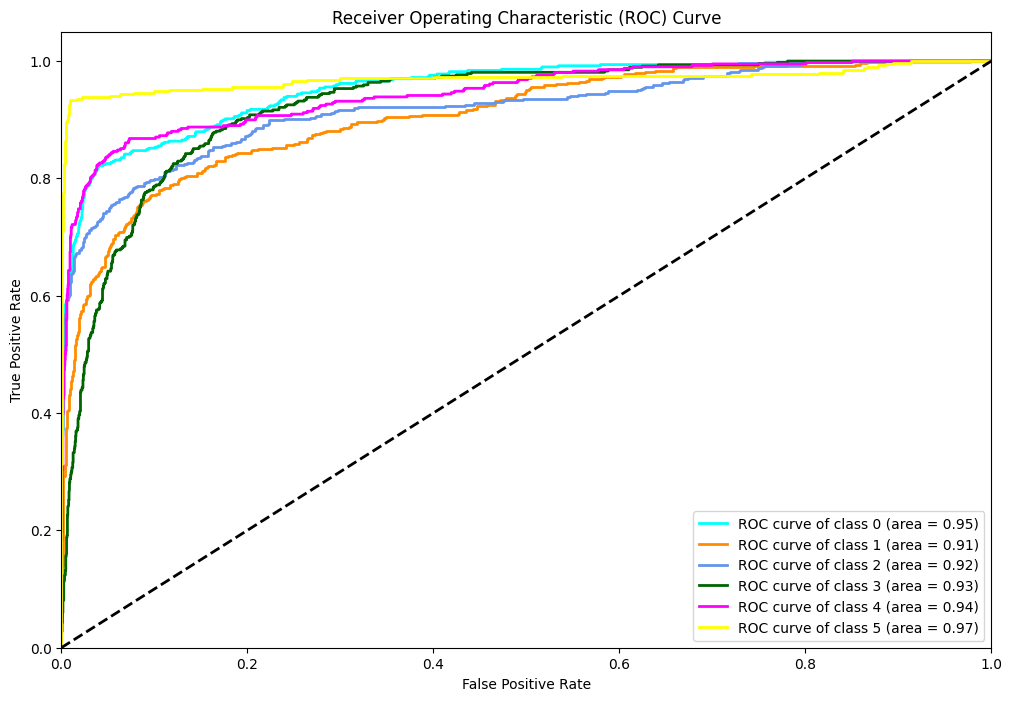

172/172 [==============================] - 40s 230ms/step
Class-wise accuracies: {'Class 0': 0.8092369477911646, 'Class 1': 0.7089397089397089, 'Class 2': 0.6756198347107438, 'Class 3': 0.7739872068230277, 'Class 4': 0.8264058679706602, 'Class 5': 0.9333333333333333}


In [17]:
# Plotting function for training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_history(history)

# Generate ROC curve and AUC
def plot_roc_curve(model, val_dataset, val_labels):
    val_probs = model.predict(val_dataset.batch(16).prefetch(tf.data.AUTOTUNE))
    val_preds = np.argmax(val_probs, axis=1)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(6):
        fpr[i], tpr[i], _ = roc_curve(val_labels, val_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'magenta', 'yellow']
    for i, color in zip(range(6), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(model, val_dataset, val_labels)

# Compute class-wise accuracy
def compute_classwise_accuracy(model, val_dataset, val_labels):
    val_probs = model.predict(val_dataset.batch(16).prefetch(tf.data.AUTOTUNE))
    val_preds = np.argmax(val_probs, axis=1)

    class_accuracies = {}
    for i in range(6):
        class_indices = np.where(np.array(val_labels) == i)
        class_correct = np.sum(np.array(val_labels)[class_indices] == val_preds[class_indices])
        class_total = len(class_indices[0])
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_accuracies[f'Class {i}'] = class_accuracy

    return class_accuracies

# Call the function to compute class-wise accuracy
class_accuracies = compute_classwise_accuracy(model, val_dataset, val_labels)
print("Class-wise accuracies:", class_accuracies)
